# TME5 - t-SNE embedding of MovieLens

- Université Pierre et Marie Curie (UPMC)
- Master Données, Apprentissage, Connaissances (DAC)
- Professeur Ludovic Denoyer
- Étudiant Rémi Cadène 3000693

Dans le précédent TME de filtrage collaboratif, nous avons projeté nos films et nos utilisateurs dans un espace latent de dimension k.
Dans ce TME, nous souhaitons projeter nos films depuis cet espace latent vers un espace en deux dimensions de façon à préserver les structures de voisinage au tour de chaque exemple. Ainsi, nous allons implémenter l'algorithme t-Distributed Stochastic Neighbor Embedding (Van Der Maaten & Hinton, 2008). Cet algorithme utilise des mesures de qualité de la représentation qui sont la trustworthiness, les voisins dans l'espace d'arrivé sont voisins dans l'espace de départ, et la continuity, les voisins dans l'espace de départ sont voisins dans l'espace d'arrivé. Puis une descente de gradient stochastic est appliquée afin de minimiser une fonction de coût impliquant ces mesures.

Dans une première section, nous appliquerons notre algorithme sur les données MNIST et comparerons nos résultats avec l'implémentation de la bibliothèque sklearn. Dans une seconde section, nous l'appliquerons à nos données de films de la base movieLens100k et interpréterons nos résultats.

Source : http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

#0. Implémentation 

## Imports

In [42]:
import numpy as np

from scipy import stats
from scipy.spatial import distance

import matplotlib.pyplot as plt
from matplotlib import offsetbox

from sklearn import datasets
from sklearn.manifold import TSNE

import pickle as pkl

%matplotlib inline  

## Chargement des données

Les fonctions pour charger les bases Movie Lens 100k et Movie Lens 1M.
On récupère un dictionnaire pour les scores et un dictionnaire pour les dates.
Le première index de ces dictionnaires est l'identifiant de l'utilisateur, et le second les films notés.

In [2]:
def loadMovieLens(path='./data100k'):
    # Get movie titles
    movies={}
    for line in open(path+'/u.item'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
    # Load data
    prefs={} # Un dictionnaire User > Item > Rating
    times={} # Un dictionnaire User > Item > Timestamps
    for line in open(path+'/u.data'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
        times.setdefault(user,{})
        times[user][movies[movieid]]=float(ts)
    return prefs, times

In [3]:
def loadMovieLens1M(path='./data1m'):
    # Get movie titles
    movies={}
    for line in open(path+'/movies.dat'):
        id,title=line.split('::')[0:2]
        movies[id]=title
    # Load data
    prefs={}
    times={}
    for line in open(path+'/ratings.dat'):
        (user,movieid,rating,ts)=line.split('::')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
        times.setdefault(user,{})
        times[user][movies[movieid]]=float(ts)
    return prefs, times

## Représentations des données

Les matrices des scores Utilisateurs/Films sont des matrices de grandes dimensions mais sparses.
Afin de les manipuler efficacement, on emploiera 3 représentations différentes en même temps:
- Le dictionnaire des scores par utilisateurs: User > Item > Value
- Le dictionnaire des scores par films: Item > User > Value 
- La liste des triplets [User, Item, Value]

In [4]:
# Recupère une représentation des données sous la forme triplets [user, item, value] a partir d'un dictionnaire [User > item > value]
def getCouplesUsersItems(data):
    couples = []
    for u in data.keys():
        for i in data[u].keys():
            couples.append([u,i,data[u][i]])
    return couples

# Construit le dictionnaire des utilisateurs a partir des triplets [user, item, note]
def buildUsersDict(couples):
    dicUsers = {}
    for c in couples:
        if not c[0] in dicUsers.keys():
            dicUsers[c[0]] = {}
        dicUsers[c[0]][c[1]] = float(c[2])
    return dicUsers

# Construit le dictionnaire des objets a partir des triplets [user, item, note]
def buildItemsDict(couples):
    dicItems = {}
    for c in couples:
        if not c[1] in dicItems:
            dicItems[c[1]] = {}
        dicItems[c[1]][c[0]] = float(c[2])
    return dicItems

## Séparation des données en Train / Test

Pour pouvoir séparer les données en ensembles de Train et de Test, on utilisera la liste des triplets [User, Item, Scores].

In [5]:
# Split l'ensemble des triplets [user, item, note] en testProp% données de test et (1 - testProp) données de train
def splitTrainTest(couples,testProp):
    perm = np.random.permutation(couples)
    splitIndex = int(testProp * len(couples))
    return perm[splitIndex:], perm[:splitIndex]

## Factorisation matricielle avec biais

Ce modèle tiens compte d'un biais propre à chaque utilisateur et un biais propre à chaque film.
On cherche donc le scalaire $\mu$ et les matrices $P$,$Q$,$B_u$,$B_i$ tel que pour les exemples $(u,i)$ connus, $PQ(u,i) + B_u(u) + B_i(i) + \mu ~= X(u,i)$, où $X$ est la matrice des scores.
Pour prédire le score d'un nouvel exemple (u',i'), il suffit de calculer $PQ(u,i) + B_u(u) + B_i(i) + \mu$

In [7]:
class matrixFactorisationBiais():
    def __init__(self, k, lambd=0.2, eps=1e-5, maxIter=10000, alternate=0):
        self.k = k
        self.lambd = lambd
        self.eps = eps
        self.maxIter = maxIter
        self.alternate = alternate
    def fit(self, dataUsers, dataItems, couples):
        self.p = {}
        self.q = {}
        self.bu = {}
        self.bi = {}
        self.mu = np.random.random() * 2 - 1
        self.loss = []
        optimP = True
        optimQ = (self.alternate == 0)
        for i in xrange(self.maxIter):
            loss = 0
            for j in xrange(len(couples)):
                r = np.random.randint(len(couples))
                user = couples[r][0]
                item = couples[r][1]
                if not user in self.p:
                    self.p[user] = np.random.rand(1,self.k) * 2 - 1
                    self.bu[user] = np.random.rand() * 2 - 1
                if not item in self.q:
                    self.q[item] = np.random.rand(self.k,1) * 2 - 1
                    self.bi[item] = np.random.rand() * 2 - 1
                tmp = dataUsers[user][item] - (self.mu + self.bi[item] + self.bu[user] + self.p[user].dot(self.q[item])[0][0])
                if (optimP):
                    self.p[user] = (1 - self.lambd * self.eps) * self.p[user] + self.eps * 2 * tmp * self.q[item].transpose()
                    self.bu[user] = (1 - self.lambd * self.eps) * self.bu[user] + self.eps * 2 * tmp
                if (optimQ):
                    self.q[item] = (1 - 2 * self.lambd * self.eps) * self.q[item] + self.eps * 2 * tmp * self.p[user].transpose()
                    self.bi[item] = (1 - 2 * self.lambd * self.eps) * self.bi[item] + self.eps * 2 * tmp
                self.mu = (1 - self.lambd * self.eps) * self.mu + self.eps * 2 * tmp
                loss = loss + tmp*tmp
            self.loss.append(loss)
            if (self.alternate != 0):
                if (i % self.alternate == 0):
                    optimP = optimQ
                    optimQ = 1 - optimQ
                    print i, loss / len(couples)
            else:
                if (i % 100 == 0):
                    print i, loss / len(couples)
    def predict(self, couplesTest):
        pred = np.zeros(len(couplesTest))
        for ind,c in enumerate(couplesTest):
            pred[ind] = self.mu + self.bu[c[0]] + self.bi[c[1]] + self.p[c[0]].dot(self.q[c[1]])[0][0]
        return pred

## t-SNE Stochastique Neighbor Embedding

- perp : perplexité
- nIter : nombre d'itération de la descente de gradient stochastique
- lr : learning rate 
- moment : coefficient du momentum 
- dim : dimension de l'espace d'arrivé

La similarité entre deux exemples $x_i$ et $x_j$ est exprimée par la probabilité conditionnelle $p_{i|j}$ telle que $x_i$ puisse avoir $x_j$ dans son voisinage serait proportionnelelle à la densité de probabilité d'une gaussienne centrée en $x_i$. Plus $p_{j|i}$ est élevé, plus les deux points ont de chance d'être proche. Notons que $p_{i|i} = 0$.
Mathématiquement, on a :
$$ p_{j|i} = \frac{ exp( -||x_i - x_j||^2 / 2 \sigma_i^2) }{ \sum_{k \neq i} exp (-||x_i - x_k||^2 / 2 \sigma_i^2)} $$

Pour ces deux mêmes exemples $x_i$ et $x_j$ est exprimée de la même manière la probabilité conditionnelle $q_{j|i}$ que leurs projections $y_i$ et $y_j$ dans l'espace d'arrivé soient proches.
Mathématiquement, on a :
$$ q_{j|i} = \frac{ exp( -||y_i - y_j||^2) }{ \sum_{k \neq i} exp (-||y_i - y_k||^2)} $$

L'algorithme t-SNE cherche à trouver la projection permettant de minimiser les disparités entre $p_{j|i}$ et $q_{j|i}$. Ainsi, il faut minimiser la somme des divergences au sens de Kullback-Leibler sur tous les exemples en utilisant la descente de gradient. La fonction de coût à minimiser s'exprime mathématiquement comme suit :
$$ C = \sum_i KL(P_i || Q_i) = \sum_i \sum_j p{j|i} log \frac{p_{j|i}}{q_{j|i}} $$

La dérivée pour chaque paramètre s'exprime mathématiquement comme suit :
$$ \frac{\partial C}{\partial y_i} = 2 \sum_j (p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(y_i - y_j) $$

Par ailleurs, avant de commencer la descente de gradient, il faut estimer les valeurs des $\sigma_i$ en utilisant le concept de perplexité. On veut que chaque $\sigma_i$ implique que $Perp(P_i)$ soit égale à notre valeur de perplexité en hyperparamètre. Avec mathématiquement :$$Perp(P_i) = 2^{H(P_i)}$$
Et H est l'entrepie de Shannon tel que :
$$H(P_i) = - \sum_j p_{j|i} log_2 p_{j|i} $$

Une variante de l'algorithme consiste à fixer tous les $\sigma_i$ à une même valeur.

In [18]:
class MyTSNE():
    def __init__(self,perp, nIter, lr, moment, dim=2):
        self.perp = perp # entre 5 et 50
        self.nIter = nIter
        self.lr = lr
        self.moment = moment
        self.dim = dim 
    def fit(self,data):
        nEx = np.shape(data)[0]
        # Matrice des distances de ||xi - xj||² #
        normx = np.sum(data**2,1)
        normx = np.reshape(normx, (1, nEx))
        distancex = normx + normx.T - 2 * data.dot(data.T)
        # Calcul des sigma ---------------------------------------------------------------#
        lperp = np.log2(self.perp)
        # initialisation bornes pour la recherche dichotomique #
        sup = np.ones((nEx,1)) * np.max(distancex)
        inf = np.zeros((nEx,1))
        self.sigma = (sup + inf) / 2.
        # recherche dichotomique #
        stop = False
        while not stop:
            # Calculer la matrice des p(i|j)
            self.pcond = np.exp(-distancex / (2. * (self.sigma**2)))
            self.pcond = self.pcond / np.sum(self.pcond - np.eye(nEx),1).reshape(nEx,1)
            # Calculer l'entropie de p(i|j)
            entropy = - np.sum(self.pcond * np.log2(self.pcond), 0)
            # Mise a jour des bornes
              # Si il faut augmenter sigma
            up = entropy < lperp 
            inf[up,0] = self.sigma[up,0]
              # Si il faut baisser sigma
            down = entropy > lperp 
            sup[down,0] = self.sigma[down,0]
            # Mise a jour de sigma et condition d'arrêt
            old = self.sigma
            self.sigma = ((sup + inf) / 2.)
            if np.max(np.abs(old - self.sigma)) < 1e-5:
                stop = True
                print np.exp(entropy)
                print self.sigma.T  
        #--------------------------------------------------------------------------#
        #initialiser y
        self.embeddings = np.zeros((self.nIter+2, nEx, self.dim))
        self.embeddings[1] = np.random.randn(nEx, self.dim) * 1e-4
        #--------------------------------------------------------------------------#
        # p(ij)
        self.pij = (self.pcond + self.pcond.T) / (2.*nEx)
        np.fill_diagonal(self.pij, 0)
        # Descente de Gradient
        loss = []
        for t in xrange(1,self.nIter+1):
            # Matrice des distances 
            normy = np.sum((self.embeddings[t]**2),1)
            normy = np.reshape(normy, (1, nEx))
            distancey = normy + normy.T - 2 * self.embeddings[t].dot(self.embeddings[t].T)
            # q(ij)
            # self.qij = (distancey.sum() + nEx*(nEx-1)) / (1 + distancey)
            # np.fill_diagonal(self.qij, 0)
            self.qij = 1 / (1 + distancey)
            np.fill_diagonal(self.qij, 0)
            self.qij = self.qij / self.qij.sum()
            # Descente de gradient
            yt = self.embeddings[t]
            tmpgrad = 4 * ((self.pij - self.qij) / (1 + distancey)).reshape(nEx, nEx,1)
            for i in range(nEx):
                dy = (tmpgrad[i] * (yt[i]-yt)).sum(0)
                self.embeddings[t+1][i] = yt[i] - self.lr * dy + self.moment * (yt[i] - self.embeddings[t-1,i])
            l = stats.entropy(self.pij, self.qij, 2).mean()
            loss.append(l)
            if t % 20 == 0:
                print t,l

In [56]:
# Scale and visualize the embedding vectors
def plot_embedding(X, digits, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
        
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 1e-2:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

#1. Embedding Digits Dataset

In [96]:
data = datasets.load_digits()

## t-SNE sklearn

In [97]:
model_sklearn = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = model_sklearn.fit_transform(data.data)

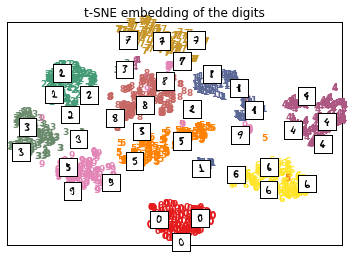

In [98]:
plot_embedding(X_tsne, data, data.target, "t-SNE embedding of the digits ")
plt.show()

## t-SNE vanilla

In [106]:
model_vanilla = MyTSNE(5,300,1000,0)
model_vanilla.fit(data.data)
X_tsne_vanilla = model_vanilla.embeddings[-1,:,:]

[ 10.19318788  10.1950449   10.19527449 ...,  10.19499785  10.19544138
  10.19517201]
[[ 4.86017051  7.70081165  9.93421268 ...,  8.8660759   8.83570836
   9.77948972]]
20 3.47863179586
40 2.71246426711
60 2.40026116564
80 2.22038109542
100 2.09863326227
120 2.00820007813
140 1.93791975311
160 1.88083774606
180 1.83317479349
200 1.79251010138
220 1.75730047932
240 1.72647938613
260 1.69918317246
280 1.67476097052
300 1.6527294961


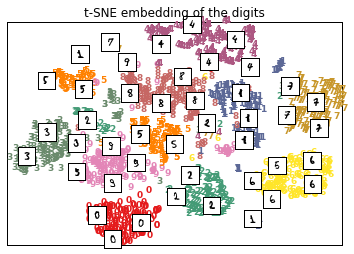

In [107]:
plot_embedding(X_tsne_vanilla, data, data.target, "t-SNE embedding of the digits ")
plt.show()

Ci-dessus, nous observons que le résultat de notre algorithme t-SNE est cohérent avec celui de sklearn. En effet, les données sont globalement regroupées en fonction de leur similarité. Certains groupes de données forment des clusters compactes. Les seules différences observées avec le t-SNE de sklearn sont issues de l'initialisation et des hyperparamètres qui ont un impact sur la convergence de l'algorithme.

#2. Embedding Movie Lens 100k

In [61]:
# Chargement
data, timestamps = loadMovieLens()

# Récupérer la représentation en liste de triplets
couples = getCouplesUsersItems(data)

# Reconstruire les dictionnaires pour l'ensemble d'apprentissage
trainUsers = buildUsersDict(couples)
trainItems = buildItemsDict(couples)

Meilleur hyperparamètres trouvés (avec une erreur en validation de  1.04966188007 ):
- lambda= 0.05
- k= 5

In [62]:
nIter = 1500
k = 5
l = .05

model_mf = matrixFactorisationBiais(k, lambd=l, maxIter=nIter, alternate=0)
model_mf.fit(trainUsers, trainItems, couples)

0 4.498939276
100 1.74785834957
200 1.42952909524
300 1.26500070114
400 1.1512894246
500 1.08742909799
600 1.03219864676
700 1.00641401589
800 0.977235356335
900 0.954907345313
1000 0.939028480709
1100 0.926758749058
1200 0.912509980924
1300 0.905515410279
1400 0.896542663045


In [63]:
if False:
    fichier = open("./model.p")
    model_mf = pkl.load(fichier)
    fichier.close()

In [73]:
# vectorization
movies = np.zeros((len(model_mf.q),k))
titles = []
for i,q in enumerate(model_mf.q.keys()):
    movies[i] = np.squeeze(reco.q[q])
    titles.append(q)

In [74]:
# apprentissage de notre modèle t-SNE
model = MyTSNE(30,1000,1e3,0)
model.fit(movies)

[  22.97672782   14.11225285  135.22084333 ...,  135.22076548  135.21764482
  135.21868358]
[[ 0.42859439  0.85719     0.08669386 ...,  0.13395817  0.15283017
   0.1387459 ]]
20 3.37145966903
40 2.96150912545
60 2.77159204274
80 2.64570679585
100 2.55400292228
120 2.48370874528
140 2.42578037458
160 2.37882011564
180 2.33949640338
200 2.30664093876
220 2.27771232266
240 2.25137427753
260 2.22781169715
280 2.20643405717
300 2.18694938404
320 2.16907455874
340 2.1523166141
360 2.13790545006
380 2.12373450688
400 2.11055354065
420 2.09787333615
440 2.08738969463
460 2.07690513243
480 2.06669407803
500 2.0565090904
520 2.04752993666
540 2.0389329153
560 2.03038194513
580 2.02189376933
600 2.01466994465
620 2.00741469891
640 1.99998041336
660 1.99348730698
680 1.98764530306
700 1.98144469908
720 1.97533376619
740 1.97005628727
760 1.96491072683
780 1.95925501233
800 1.95439048771
820 1.94995128806
840 1.94515082687
860 1.94022921469
880 1.93614334861
900 1.93222244973
920 1.92780390888
940 

/users/nfs/Etu3/3000693/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log2
/users/nfs/Etu3/3000693/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: invalid value encountered in multiply
/users/nfs/Etu3/3000693/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: invalid value encountered in less
/users/nfs/Etu3/3000693/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: invalid value encountered in greater


(1002, 1664, 2)
à droite :
(array([ 34.34002383,   5.51342458]), u'Glimmer Man, The (1996)')
(array([ 34.55169049,   4.96145074]), u'Fearless (1993)')
(array([ 34.65287278,  -4.75373773]), u'Kicking and Screaming (1995)')
(array([ 34.60553537,   6.3593533 ]), u'Neon Bible, The (1995)')
(array([ 34.3165433 ,   5.29718591]), u'Maximum Risk (1996)')
(array([ 34.08057039,   6.2319915 ]), u'Canadian Bacon (1994)')
à gauche :
(array([-33.26129119,   0.82407333]), u'Unbearable Lightness of Being, The (1988)')
(array([-33.23254475,   0.34248829]), u'Three Colors: Blue (1993)')
(array([-33.74493389,  10.02322665]), u'Golden Earrings (1947)')
(array([-34.13011909,   6.02190296]), u'Caught (1996)')
en haut :
(array([ 12.70923503,  31.16903488]), u'Boys (1996)')
(array([  6.73592877,  31.24787011]), u'Nil By Mouth (1997)')
(array([ -2.40508541,  31.45841624]), u"My Best Friend's Wedding (1997)")
(array([ -8.93678434,  32.01119578]), u'Faces (1968)')
en bas :
(array([ -1.52993886, -32.72870648]), u

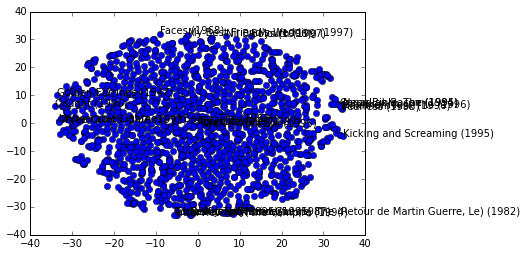

In [94]:
t = -1

plt.figure()
plt.plot(model.embeddings[t,:,0],model.embeddings[t,:,1], 'o', color="blue")

print(model.embeddings.shape)

print 'à droite :'
for i, txt in enumerate(titles):
    if model.embeddings[t,i][0] > 34.0:
        print(model.embeddings[t,i], txt.decode('latin-1'))
        plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])

print 'à gauche :'       
for i, txt in enumerate(titles):        
    if model.embeddings[t,i][0] < -33.0:
        print(model.embeddings[t,i], txt.decode('latin-1'))
        plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])
        
print 'en haut :'       
for i, txt in enumerate(titles):        
    if model.embeddings[t,i][1] > 31.0:
        print(model.embeddings[t,i], txt.decode('latin-1'))
        plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])

print 'en bas :'       
for i, txt in enumerate(titles):        
    if model.embeddings[t,i][1] < -32.5:
        print(model.embeddings[t,i], txt.decode('latin-1'))
        plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])

print 'au milieu :'
for i, txt in enumerate(titles): 
    if model.embeddings[t,i][0] < 1 and model.embeddings[t,i][0] > -1 and model.embeddings[t,i][1] < 1 and model.embeddings[t,i][1] > -1 :
        print(model.embeddings[t,i], txt.decode('latin-1'))
        plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])        
        
plt.show()

Ci-dessus, nous constatons que la projection en deux dimensions de nos données avec l'algorithme t-SNE ne nous permet pas de visualiser une structure cohérente malgré qu'il n'ait pas divergé.